# Modify a CTI CCF file

This notebook reads a CCF file and adds a line (or lines) with new rows.

In this particular example, for `MODE_ID=3` (PN Small Window Mode) I extrapolate linearly a new energy point at 10 keV for each TCOEFF. I use the two points at 5.8988 and 6.4 keV.



In [1]:
import os
import numpy as np
import time

from astropy.io import fits
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
home = os.path.expanduser('~')
wdir = home + "/IVAN/ccfdev"

In [2]:
today = time.strftime("%c")
#
ccfdir = '/ccf/pub'
ccf_file = f"{ccfdir}/EPN_CTI_0049.CCF"
hdu = fits.open(f"{ccf_file}")
ltc = hdu['LONG_TERM_CTI']
#
times = hdu['LTC_TIMES'].data["TIME"][0]
ix = np.where(ltc.data['MODE_ID'] == 3)[0]
xtab = ltc.data[ix]
loge1 = np.log10(xtab['ENERGY'][0])
tc1 = xtab['T_COEFF'][0]
loge5 = np.log10(xtab['ENERGY'][1])
tc5 = xtab['T_COEFF'][1]
loge6 = np.log10(xtab['ENERGY'][2])
tc6 = xtab['T_COEFF'][2]
loge10 = 1.0 # 10 keV

In [3]:
#
# now extrapolate from the two points at loge5 and loge6 to loge10
#
# y - y2 = (y2-y1)/(x2-x1) * (x - x2)
#
y2 = tc6
y1 = tc5
x2 = loge6
x1 = loge5
x = loge10
slope = (y2 - y1)/(x2-x1)
y = y2 + slope*(x-x2)
#

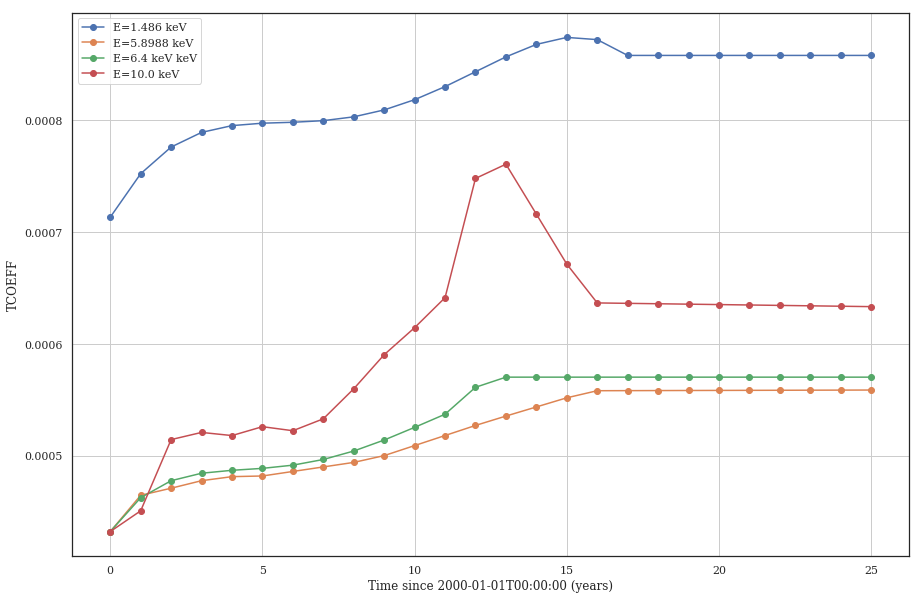

In [4]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(times,tc1,'-o',label="E=1.486 keV")
ax.plot(times,y1,'-o',label="E=5.8988 keV")
ax.plot(times,y2,'-o',label="E=6.4 keV keV")
ax.plot(times,y,'-o',label="E=10.0 keV")
ax.set_xlabel("Time since 2000-01-01T00:00:00 (years)")
ax.set_ylabel("TCOEFF")
ax.legend()
ax.grid()
plt.show();

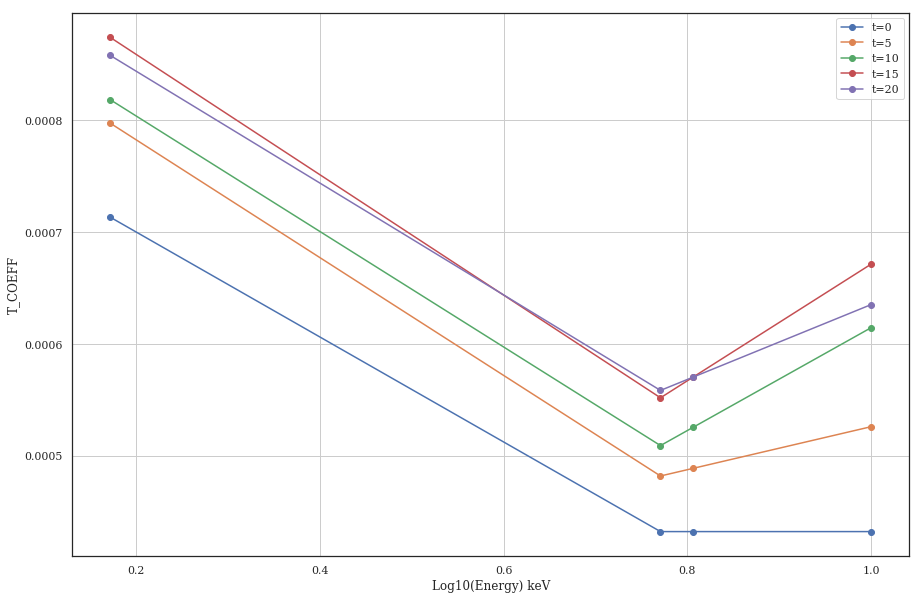

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
for i in np.arange(25):
    if (i % 5 == 0):
        ax.plot([loge1,x1,x2,x],[tc1[i],y1[i],y2[i],y[i]],'-o',label=f"t={i}")
ax.set_xlabel("Log10(Energy) keV")
ax.set_ylabel("T_COEFF")
ax.legend()
ax.grid()
plt.show();

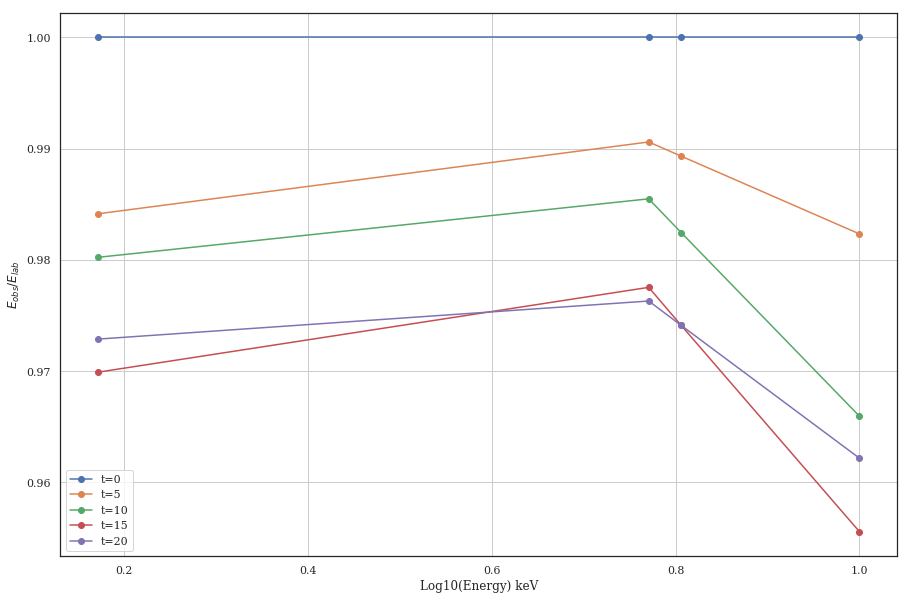

In [11]:
gt1 = np.power((1.0 - tc1)/(1.0-tc1[0]),190.0)
gt5 = np.power((1.0 - y1)/(1.0-y1[0]),190.0)
gt6 = np.power((1.0 - y2)/(1.0-y2[0]),190.0)
gt10 = np.power((1.0 - y)/(1.0-y[0]),190.0)

fig, ax = plt.subplots(figsize=(15,10))
for i in np.arange(25):
    if (i % 5 == 0):
        ax.plot([loge1,x1,x2,x],[gt1[i],gt5[i],gt6[i],gt10[i]],'-o',label=f"t={i}")
ax.set_xlabel("Log10(Energy) keV")
ax.set_ylabel("$E_{obs}/E_{lab}$")
ax.legend()
ax.grid()
plt.show();

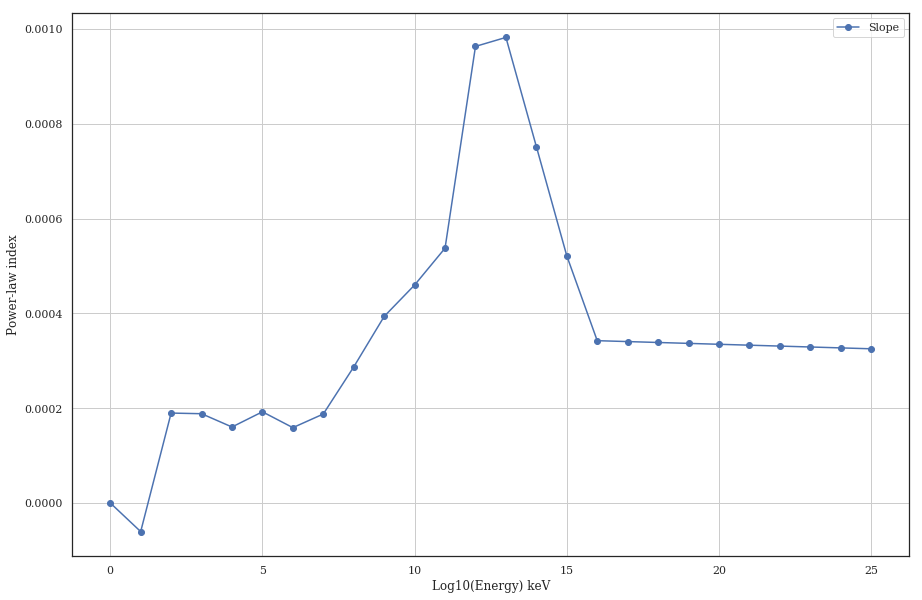

In [47]:
#
# check the slope
#
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(times,slope,'-o',label=f"Slope")
ax.set_xlabel("Log10(Energy) keV")
ax.set_ylabel("Power-law index")
ax.legend()
ax.grid()
plt.show();

In [41]:
nrows = ltc.data.shape[0]
xhdu = fits.BinTableHDU.from_columns(ltc.columns, nrows=nrows+1,name='LONG_TERM_CTI',header=ltc.header)
# now adding a new row for the TCOEFF
xhdu.data['MODE_ID'][nrows] = 3
xhdu.data['CCD_ID'][nrows] = 4
xhdu.data['ENERGY'][nrows] = 10.0
xhdu.data['T_COEFF'][nrows] = y
xhdu.data['SHIFT'][nrows] = 1
#
idx_sorted = np.lexsort((xhdu.data['ENERGY'],xhdu.data['CCD_ID'],xhdu.data['MODE_ID']))
xhdu.data = xhdu.data[idx_sorted]
xhdu.header.remove('HISTORY',remove_all=True)
xhdu.header.add_history(f'Created by Ivan V, {today}')
hdu['LONG_TERM_CTI'] = xhdu
hdu[0].header['FILENAME'] = "EPN_CTI_0051.CCF"
hdu.writeto(f"{wdir}/EPN_CTI_0051.CCF_test10keV",overwrite=True)
hdu.close()